# On the Menzerath's law in portuguese - using ABG Corpus

This notebook provides the step by step used in the analysis of the Menzerath's law on portuguese and english. 

,,je größer das Ganze, um so kleiner die Teile!'' (Paul Menzerath, 1954)

Altmann (1980) formulated:

\begin{equation}\label{eq-dif-altmann}
\frac{ \mathrm{d}y / \mathrm{d}x }{y} = -c + \frac{b}{x} ,
\end{equation}


with solution

\begin{equation}
y = A x^b e^{-c x} .
\end{equation}


We might use three different models from this solution. They are presented in the table bellow:


| parameters              | equation             | name      |
|-------------------------|----------------------|-----------|
| $b=0$                   | $y=Ae^{-cx}$         | model I   |
| $b\neq 0$ and $c=0$     | $y=Ax^b$             | model II  |
| $b\neq 0$ and $c\neq 0$ | $y=Ax^b e^{-cx}$     | model III |

In [51]:
# check if ABG corpus was already downloaded
# if not, download it
if [ ! -f /tmp/Corpus_ABG.csv ]; then 
  wget -q https://raw.githubusercontent.com/SauronGuide/corpusABG/master/Corpus_ABG_Completo_Versao3.csv -O /tmp/Corpus_ABG.csv
fi

Lets check the type of file we have downloaded:

In [52]:
file /tmp/Corpus_ABG.csv

/tmp/Corpus_ABG.csv: UTF-8 Unicode (with BOM) text, with CRLF line terminators


Since it uses CRLF line terminators, it was probably created on Windows. This double line terminator is unnacessary and carries an extra byte ('\r', carriage return) that might appear as ^M on Linux and create further problem.

The BOM marker is also redundant, since it is possible to infer the endianness by a simple analysis of the data. The BOM marker (in UTF-8) is made of the three inicial bytes ```0xEF```,```0xBB```,```0xBF```.

So let's start by removing both of them.

In [53]:
tail --bytes=+4 /tmp/Corpus_ABG.csv | tr -d '\r' > /tmp/CorpusABG.csv

Unfortunately the ABG corpus has many erros. We will try to fix some of them and leave many behind. 

The first error we found is empty lines, that appear as: ```,,,,,,,,,,,,,,,,```.

Lets list them and remove them. We will use grep to find them and the parameter ```-n``` to print the line number, along the match.

In [54]:
grep -n '^,' /tmp/CorpusABG.csv 

20608:,,,,,,,,,,,,,,,,
20747:,,,,,,,,,,,,,,,,
20957:,,,,,,,,,,,,,,,,
48422:,,,,,,,,,,,,,,,,
48764:,,,,,,,,,,,,,,,,
49034:,,,,,,,,,,,,,,,,
49705:,,,,,,,,,,,,,,,,
49838:,,,,,,,,,,,,,,,,
50175:,,,,,,,,,,,,,,,,
51587:,,,,,,,,,,,,,,,,
53205:,,,,,,,,,,,,,,,,
92625:,,   ,,,,,,,,,,,,,,


In [55]:
LINES=""; 
for i in `grep -n '^,' /tmp/CorpusABG.csv | cut -d: -f1`; do 
  LINES="${LINES}${i}d;"; 
done; 
sed -ie "${LINES}" /tmp/CorpusABG.csv

Another type of error we found in the database is lines with more fields than others. Probably the authors have inserted erroneous commas, creating a malformed file. The script bellow present the rows that have more than 12 fields. We also print the line number, so we may once again remove the bad data.

In [56]:
cat /tmp/CorpusABG.csv | sed 's/,\+\s*$//' | awk -F, 'NF>12{print NR":"$0}'

46495:46508,prociss?es,   NP,,   prociss?es,   &pro-si-sOJs*,   &pro-si-s#Js*,   &CCV-CV-CVGS*,   ox?tona,2,2,   0e,2
54571:54607,Juvenile,   NOM,   Juvenile,   &ju-ve-ni-le*,   &ju-ve-n7-ly*,   &CV-CV-CV-CV*,   parox?tona,1,   0o,1,,54607
77325:77959,bulut,   F,   bulut,   &bu-lut*,   &bu-l$t*,   &CV-CVC*,   ox?tona,1,   0o,1,1,,1,   0o,1,1


Lets then remove those lines, just as we did before.

In [57]:
LINES=""; 
for i in `sed 's/,\+\s*$//' < /tmp/Corpus_ABG.csv | awk -F, 'NF>12{print NR":"$0}' | cut -d: -f1`; do 
  LINES="${LINES}${i}d;"; 
done; 
sed -ie "${LINES}" /tmp/CorpusABG.csv

There are also rows where the FREQGERAL is zero or not a number. We're going to remove these data as well.

In [58]:
awk -F, '$9<1{print NR":"$0}' < /tmp/CorpusABG.csv

24089:24093,Jereissati,   F   jereissati,   &je-reJ-sa-Ti*,   &je-reJ-s1-Ty*,   &CV-CVG-CV-CV*,   parox?tona,6,   0o,6,2,,,,,
35806:35816,Fuentes,   F   Fuentes,   &fE-tes*,   &fE-t4s*,   &CV-CVS*,   ox?tona,3,   0o,3,2,,,,,
46495:46508,prociss?es,   NP,,   prociss?es,   &pro-si-sOJs*,   &pro-si-s#Js*,   &CCV-CV-CVGS*,   ox?tona,2,2,   0e,2,,,,,
51340:51359,Josh,   F   Josh,   &jo-Sy*,   &j9-Sy*,   &CV-CV*,   parox?tona,2,   0o,2,2,,,,,


In [59]:
LINES=""; 
for i in `awk -F, '$9<1{print NR":"$0}' < /tmp/CorpusABG.csv | cut -d: -f1`; do 
  LINES="${LINES}${i}d;"; 
done; 
sed -ie "${LINES}" /tmp/CorpusABG.csv

Now lets create a database file from CorpusABG, where it will have the following fields: word, frequency, phonetic transcription, phone length, syllabic transcription, syllable length.

ABG corpus has an empty line in the end, what we will eliminate. We will also change the header (first line) to use the labels given above.

In [60]:
echo "word,frequency,phonetic transcription,phone length,syllabic transcription,syllable length,average duration" > /tmp/corpusabg.csv
cat /tmp/CorpusABG.csv | head -n -1 | tail -n +2 | 
    awk -F',' '{gsub(/^[ \t]+|[ \t]+$/, "", $5); gsub(/^\&|\*$/,"",$5); gsub(/^[ \t]+|[ \t]+$/, "", $7); gsub(/^\&|\*$/,"",$7); printf "%s,%d,%s,", tolower($2), $9, $5; gsub(/-/,"",$5); printf "%d,%s,%d\n", length($5), $7, gsub(/-/,"",$7)+1}' >> /tmp/corpusabg.csv

Note that we have copied the data from the orginal database and computed the missing desired fields: phone length and syllable length.


Using the new corpus, saved at ```/tmp/corpusabg.csv``` we may count the number of words with a given number of syllables and a given averange phone length per syllable. In order to do so, we just need to use column 6 (syllable length) and column 4 divided by column 6 (phone length/syllable length). The script bellows compute this value and count the number of occurrence.

In [61]:
cat /tmp/corpusabg.csv | tail -n +2 | awk -F',' '{print $6 "\t" $4/$6}' | 
   sort | uniq -c | sort -rn > /tmp/counts_numsyl_avgphlen
sed -i '1icount\tnum_syllables\tavg_phone_length' /tmp/counts_numsyl_avgphlen 
head /tmp/counts_numsyl_avgphlen

count	num_syllables	avg_phone_length
  11823 3	2.33333
   9720 3	2
   9170 4	2.25
   8245 4	2
   7579 2	2.5
   5695 3	2.66667
   5230 2	2
   4682 4	2.5
   3839 5	2.2


Let's use this new data to create a density plot for the relation between number of syllables and average syllable length (phones/syllable).

svg 
  3

png 
  2

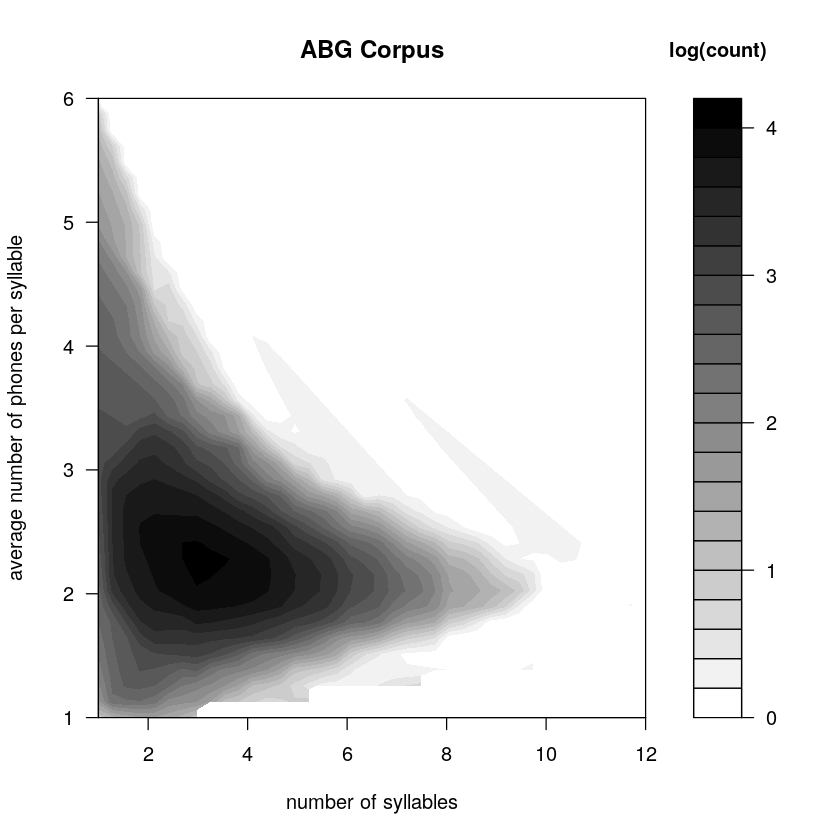

In [62]:
df <- read.table("/tmp/counts_numsyl_avgphlen",header=TRUE)
library(akima)
fld <- with(df, interp(x = num_syllables, y = avg_phone_length, z = count))
filled.contour(x = fld$x,
               y = fld$y,
               z = log10(fld$z),
               color.palette =
                 colorRampPalette(c("white", "black")),
               xlab = "number of syllables",
               ylab = "average number of phones per syllable",
               main = "ABG Corpus",
               key.title = title(main = "log(count)", cex.main = 1))
dev.copy(svg,"/tmp/counts_numsyl_avgphlen.svg")
dev.off()

In the plot above we have considered the number of types (words) found in the ABG Corpus for a given relation between number of syllables and average number of phones per syllable.

The corpus also have the frequency of occurrence of each word. We might take that in account and do the same graph again. Now we shall have a density plot considering the token frequency for each relation between number of syllables and average number of phones per syllable.

In [63]:
cat /tmp/corpusabg.csv | tail -n +2 | awk -F',' '{print $6 "\t" $4/$6 "\t" $2}' | awk 'BEGIN{OFS="\t"} {count[$1,$2]+=$3;} END{for (key in count) {split(key,a,SUBSEP); print count[a[1],a[2]], a[1], a[2]}}' | sort -rn > /tmp/freq_numsyl_avgphlen
sed -i '1ifreq_occ\tnum_syllables\tavg_phone_length' /tmp/freq_numsyl_avgphlen 
head /tmp/freq_numsyl_avgphlen

freq_occ	num_syllables	avg_phone_length
683103	1	2
439736	2	2
420484	2	2.5
379262	1	1
304309	1	3
236698	3	2
230947	3	2.33333
196936	2	1.5
90642	2	3


svg 
  3

png 
  2

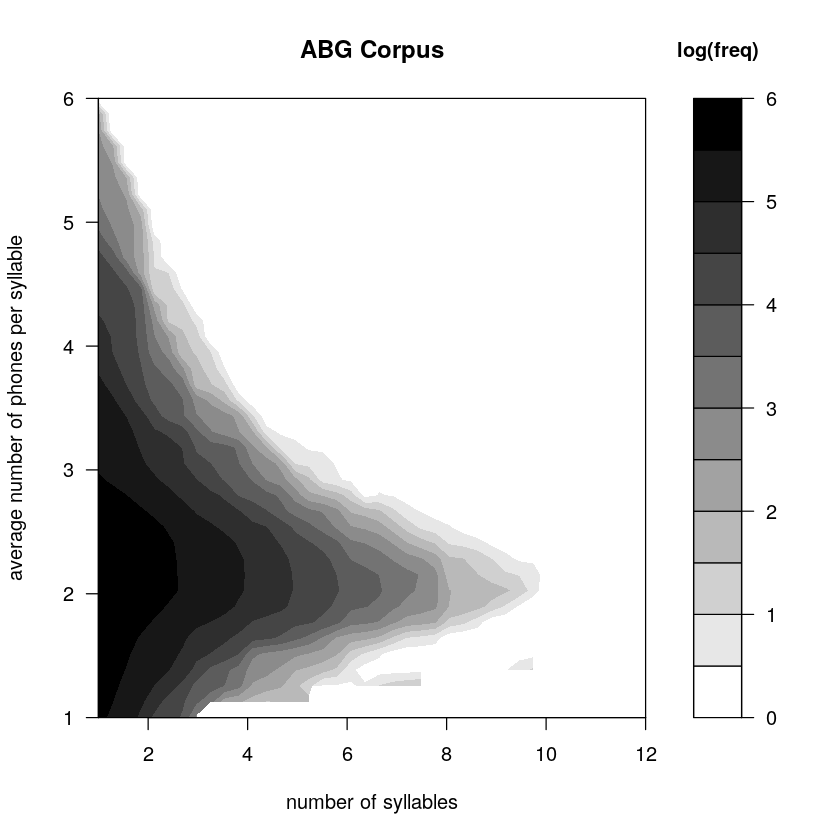

In [64]:
df <- read.table("/tmp/freq_numsyl_avgphlen",header=TRUE)
library(akima)
fld <- with(df, interp(x = num_syllables, y = avg_phone_length, z = freq_occ))
filled.contour(x = fld$x,
               y = fld$y,
               z = log10(fld$z),
               color.palette =
                 colorRampPalette(c("white", "black")),
               xlab = "number of syllables",
               ylab = "average number of phones per syllable",
               main = "ABG Corpus",
               key.title = title(main = "log(freq)", cex.main = 1))
dev.copy(svg,"/tmp/freq_numsyl_avgphlen.svg")
dev.off()

We will now load the data from ```corpusabg.csv``` in R to make plots, fit the models and analyze the results.

The average phone length for the syllables in a given word is easily computed from the number of phones and syllables in that word.

In [65]:
# read the database
abg <- read.csv("/tmp/corpusabg.csv")
# add a new field: average phone length
abg$avgphone.length <- abg$phone.length/abg$syllable.length
summary(abg)

            word         frequency               phonetic.transcription
 reprodu??o   :   10   Min.   :     1.00   os               :   12     
 s?           :   10   1st Qu.:     1.00   as               :   11     
 educa??o     :    9   Median :     2.00   ma-ni-fes-ta-sOJs:   10     
 est?         :    9   Mean   :    39.04   to-mas           :   10     
 introdu??o   :    9   3rd Qu.:     6.00   tra-ba-La-do-res :   10     
 manifesta??es:    9   Max.   :125749.00   e-du-ka-sAW      :    9     
 (Other)      :92548                       (Other)          :92542     
  phone.length    syllabic.transcription syllable.length  average.duration
 Min.   : 1.000   CV-CV-CV   : 5583      Min.   : 1.000   Mode:logical    
 1st Qu.: 6.000   CV-CV      : 3696      1st Qu.: 3.000   NA's:92604      
 Median : 8.000   CV-CV-CV-CV: 3505      Median : 3.000                   
 Mean   : 7.722   V-CV-CV-CV : 1763      Mean   : 3.471                   
 3rd Qu.: 9.000   CV-CV-CVS  : 1730      3rd Qu.:

In order to plot the relation between syllable length (syllen) and average phone length (avgphlen), we will create a new dataset where we have unique pairs (syllen, avgphlen) and the number of occurrence of these relations is counted. In the plot bellow the count is represent by the ball size.

In [66]:
# create a database with unique occurrence of each pair of coordinates (avgphone.length, syllable.length)
# adding the number of samples (types/words) with the same coordinate and accumulated frequency to variables 'value' (type frequency) and 'frequency' (token frequency)
#    'value' : number of words with the same (avgphone.length, syllable.length)
#    'frequency' : accumulated frequency of all words with the same (avgphone.length, syllable.length)
df2 <- cbind(unique(abg[,c("phone.length","syllable.length","avgphone.length")]), value = with(abg, tapply(avgphone.length, paste(avgphone.length,syllable.length), length)), frequency = with(abg, tapply(frequency, paste(avgphone.length,syllable.length), sum)))

# x and y tick arrays
atx <- seq(from = 1, to = max(df2$syllable.length), by = 1)
aty <- seq(from = 1, to = max(df2$phone.length), by = 2)

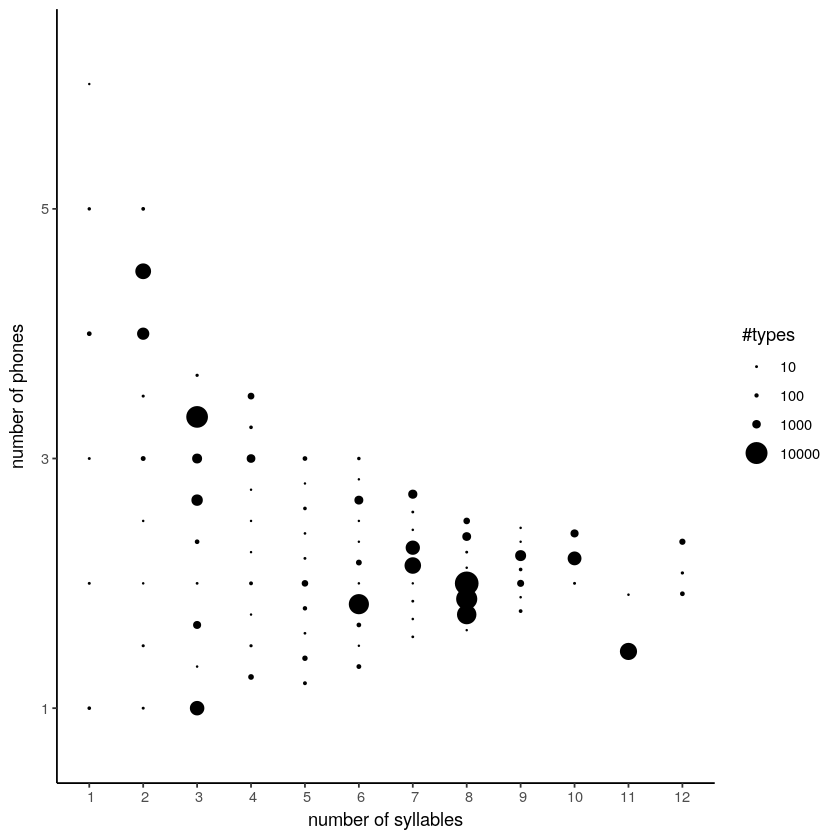

In [67]:
library(ggplot2)
ggplot(df2, aes(syllable.length, avgphone.length, size = value)) + geom_point() + theme_classic() + labs(x = "number of syllables", y = "number of phones") + scale_x_discrete(limits=atx) + scale_y_discrete(limits=aty) + scale_size_area("#types", breaks=c(10,100,1000,10000))

In [68]:
# create a dataframa with mean values 
avgfl <- sapply(split(abg$avgphone.length, abg$syllable.length), mean)
dmdf <- data.frame(atx=atx, avgfl=avgfl)

### Fitting linear models

The ```lm``` function in R is used to fit linear models. Bellow we use this function to fit the models I, II and III described above.

In [69]:
### fit linear model BEGIN ###
# y : avgphone.length
# x : syllable.length (idenpendente variable)

# create predict data frame
pdflm <- as.data.frame( list(syllable.length=seq(from=1,to=max(df2$syllable.length))) )

# model   I : log y = log A - c x
model1 <- lm(log(avgphone.length)~syllable.length, data=abg)
predlm1 <- predict(model1, newdata = pdflm, interval = "confidence")
colnames(predlm1) <- c('fit1','lwr1','upr1')
pdflm <- cbind(pdflm, predlm1)

# model  II : log y = log A + b log x
model2 <- lm(log(avgphone.length)~log(syllable.length), data=abg)
predlm2 <- predict(model2, newdata = pdflm, interval = "confidence")
colnames(predlm2) <- c('fit2','lwr2','upr2')
pdflm <- cbind(pdflm, predlm2)

# model III : log y = log A + b log x - c x
model3 <- lm(log(avgphone.length)~log(syllable.length)+syllable.length, data=abg)
predlm3 <- predict(model3, newdata = pdflm, interval = "confidence")
colnames(predlm3) <- c('fit3','lwr3','upr3')
pdflm <- cbind(pdflm, predlm3)
### fit linear model END ###

### The Null Hypothesis

We are considering the following null hypothesis: the average length of syllables (regarding the number of phones they are buit on) is constant, for any word length (in number of syllables).

In [70]:
# null hypothesis
mH0 = log(mean(abg$avgphone.length))  # mean value for null hypothesis (variation in x do not influence y)           

The plot bellow shows the data used, the models fitted and the null hypothesis.

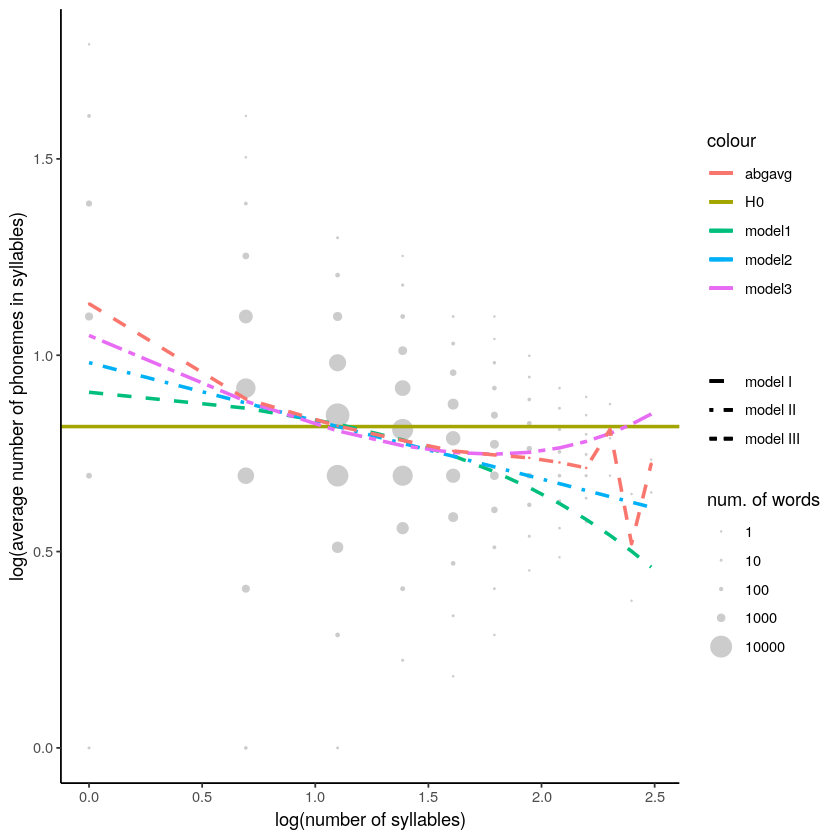

In [71]:
ggplot(abg, aes(log(syllable.length), log(avgphone.length))) +
     geom_count(colour="gray80") +
     scale_size_area(name="num. of words", breaks = c(1,1E1,1E2,1E3,1E4,1E5)) +
     theme_classic() +
     labs(x = "log(number of syllables)", y = "log(average number of phonemes in syllables)") +
     geom_hline(data=pdflm, aes(yintercept = mH0, colour="H0"), size = 1) +
     geom_line(data=pdflm, aes(y = fit1, colour="model1", linetype="model1"), size = 1) +
     geom_line(data=pdflm, aes(y = fit2, colour="model2", linetype="model2"), size = 1) +
     geom_line(data=pdflm, aes(y = fit3, colour="model3", linetype="model3"), size = 1) +
     geom_line(data=dmdf, aes(log(atx), log(avgfl), colour = "abgavg"), linetype = "dashed", size = 1) +
     geom_point(data=dmdf, aes(log(atx), log(avgfl), colour = "abgavg", size = 3), show.legend = FALSE) +
     scale_linetype_manual(values = c("H0"="dotted","model1"="dashed","model2"="dotdash","model3"="twodash","abgavg"="longdash"), labels = c("H0"="H0","model1"="model I","model2"="model II","model3"="model III","abgavg"="Corpus ABG"), name = "")

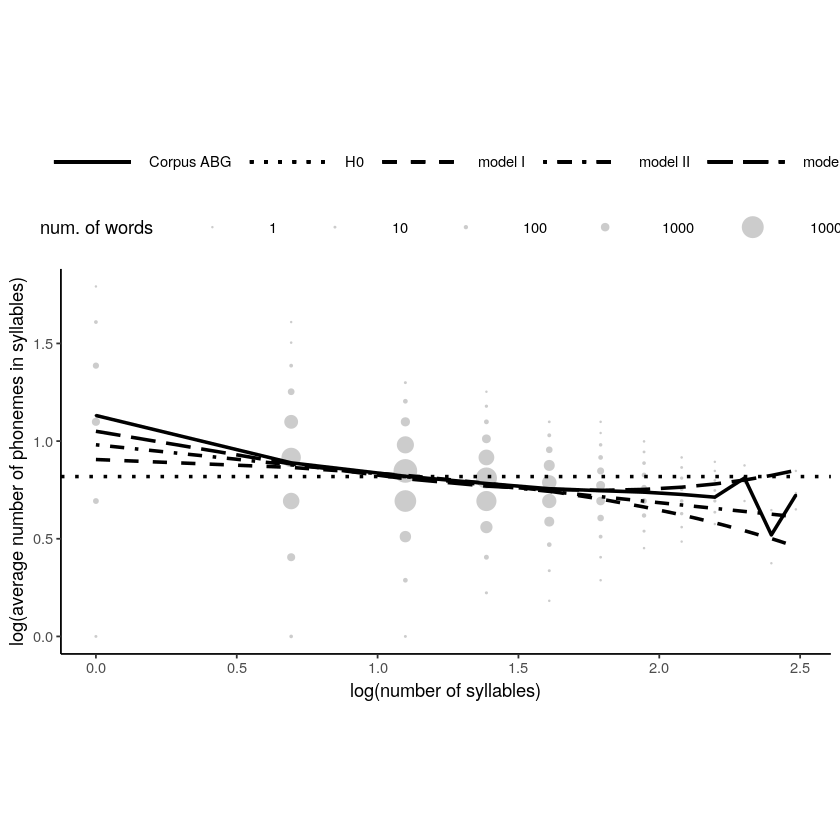

In [72]:
#### B&W Plot #####
ggplot(abg, aes(log(syllable.length), log(avgphone.length))) +
     geom_count(colour="gray80") +
     scale_size_area(name="num. of words", breaks = c(1,1E1,1E2,1E3,1E4,1E5)) +
     theme_classic() +
     labs(x = "log(number of syllables)", y = "log(average number of phonemes in syllables)") +
     geom_hline(data=pdflm, aes(yintercept = mH0, linetype="H0"), size = 1) +
     geom_line(data=pdflm, aes(y = fit1, linetype="model1"), size = 1) +
     geom_line(data=pdflm, aes(y = fit2, linetype="model2"), size = 1) +
     geom_line(data=pdflm, aes(y = fit3, linetype="model3"), size = 1) +
     geom_line(data=dmdf, aes(log(atx), log(avgfl), linetype = "abgavg"), size = 1) +
     geom_point(data=dmdf, aes(log(atx), log(avgfl), size = 3), show.legend = FALSE) +
     scale_linetype_manual(values = c("H0"="dotted","model1"="dashed","model2"="dotdash","model3"="longdash","abgavg"="solid"), labels = c("H0"="H0","model1"="model I","model2"="model II","model3"="model III","abgavg"="Corpus ABG"), name = "") +
     theme(legend.key.width = unit(4, "line"), legend.position="top", legend.justification="left", legend.direction="horizontal", legend.box = "vertical", aspect.ratio=0.5)

The models fitted by ```lm``` have their result summarized in table created by the ```stargazer``` library.

We create a funtion to save the result in a ```.tex``` file and a standalone table is represeted bellow.

In [73]:
library(stargazer)
#stargazer(model1, model2, model3, title="Regression Results", align=TRUE)
### function to save to file ###
mod_stargazer <- function(output.file, ...) {
          output <- capture.output(stargazer(...))
  cat(paste(output, collapse = "\n"), "\n", file=output.file, append=TRUE)
}
###
mod_stargazer('/tmp/modelsregressionresults_abg_ln.tex', model1, model2, model3, title="Regression Results", align=TRUE)

In [74]:
echo "\documentclass[border=3mm,preview]{standalone}
\usepackage[landscape]{geometry}
\usepackage{dcolumn}
\begin{document}
\scriptsize
\input{/tmp/modelsregressionresults_abg_ln.tex}
\end{document}" > /tmp/table.tex
pdflatex /tmp/table.tex > /dev/null 2>&1
convert -density 150 -strip /tmp/table.pdf /tmp/table.png

![ABG Menzerath Table Models Fit](images/abg_menzerath_table.png)

### Residual analysis

The analysis of residuals plays an important role in validating the regression model. 

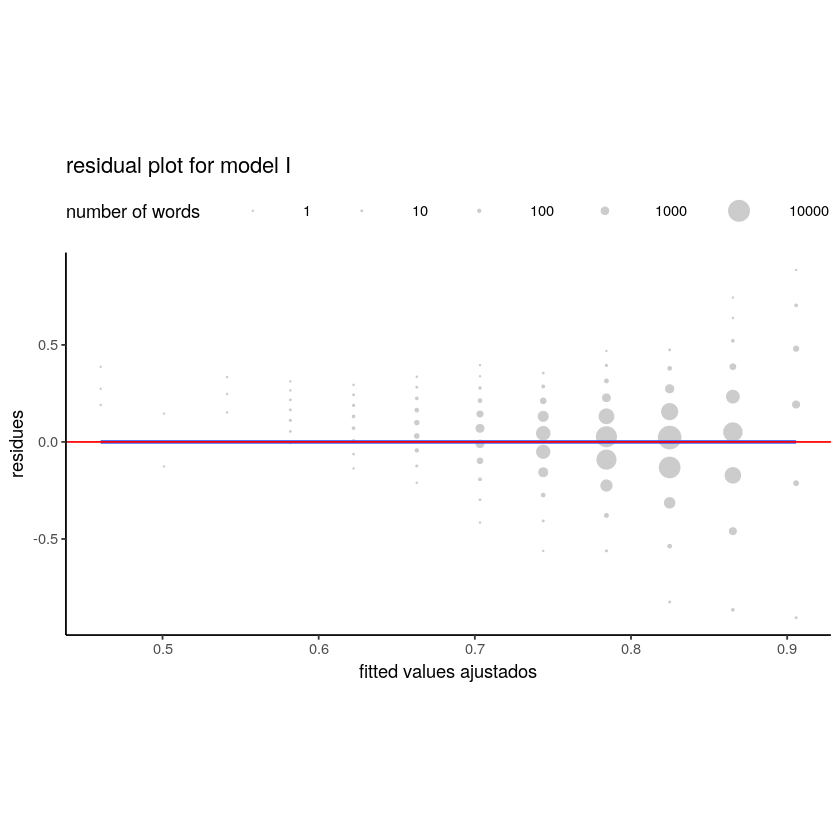

In [75]:
# residual plot for model I
modf <- fortify(model1)
ggplot(modf, aes(x = .fitted, y = .resid)) + 
    geom_count(colour="gray80") + 
    scale_size_area(name="number of words", breaks = c(1,1E1,1E2,1E3,1E4,1E5)) + 
    geom_smooth(se = FALSE, method = "gam") + geom_hline(yintercept = 0, colour = "red") + 
    theme_classic() + 
    labs(x = "fitted values ajustados", y = "residues") +
    theme(legend.key.width = unit(4, "line"), legend.position="top", legend.justification="left", legend.direction="horizontal", legend.spacing.x = unit(0.05, 'cm'), legend.box = "vertical", aspect.ratio=0.5) +
    ggtitle("residual plot for model I")

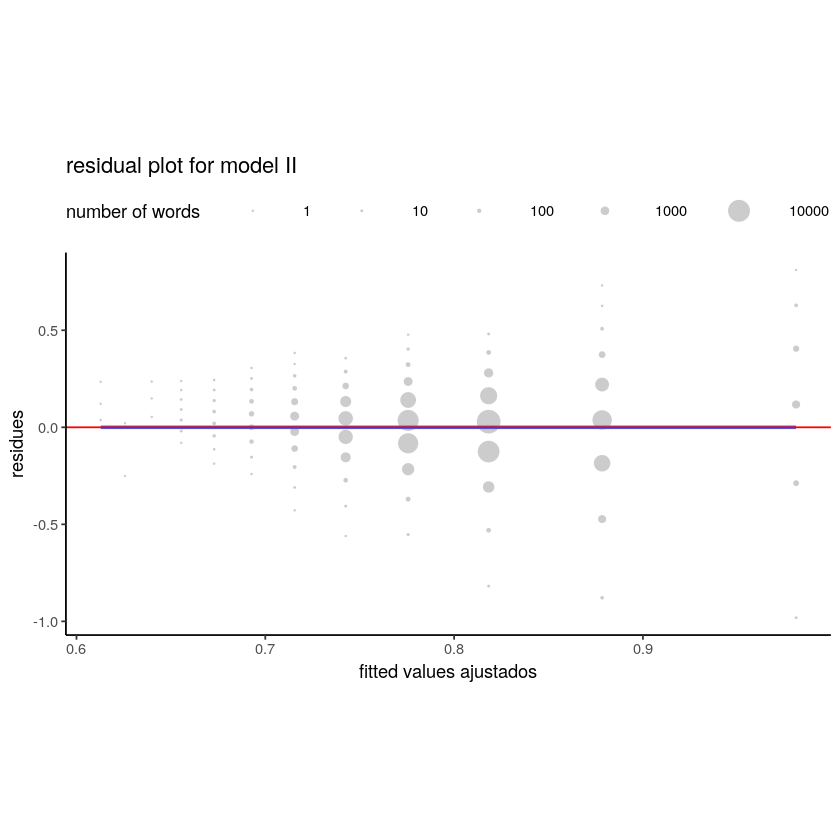

In [76]:
# residual plot for model II
modf <- fortify(model2)
ggplot(modf, aes(x = .fitted, y = .resid)) + 
    geom_count(colour="gray80") + 
    scale_size_area(name="number of words", breaks = c(1,1E1,1E2,1E3,1E4,1E5)) + 
    geom_smooth(se = FALSE, method = "gam") + geom_hline(yintercept = 0, colour = "red") + 
    theme_classic() + 
    labs(x = "fitted values ajustados", y = "residues") +
    theme(legend.key.width = unit(4, "line"), legend.position="top", legend.justification="left", legend.direction="horizontal", legend.spacing.x = unit(0.05, 'cm'), legend.box = "vertical", aspect.ratio=0.5) +
    ggtitle("residual plot for model II")

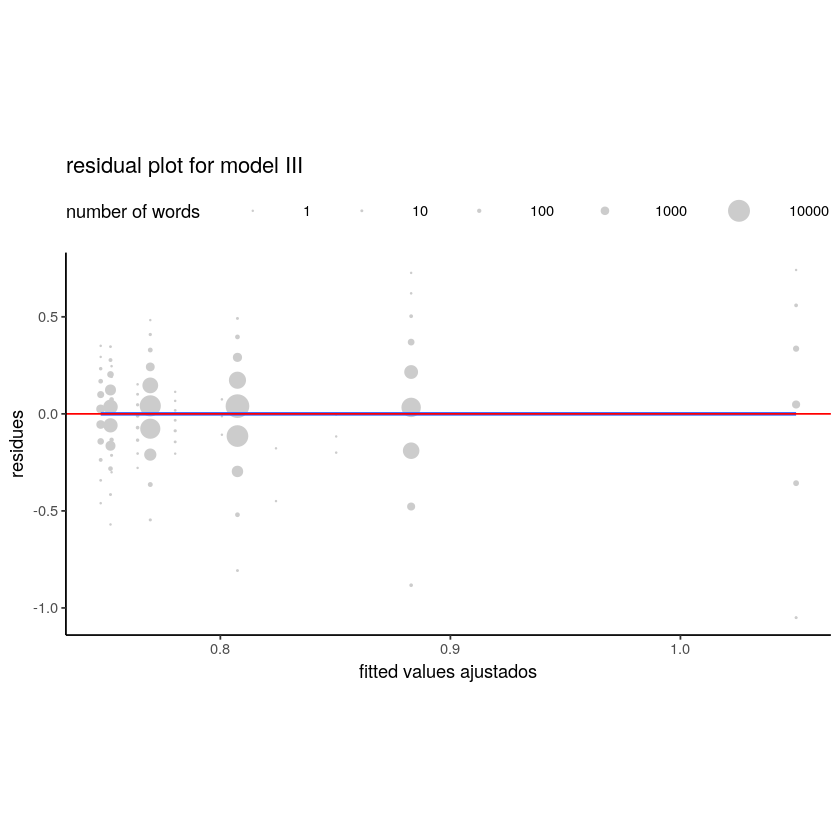

In [77]:
# residual plot for model III
modf <- fortify(model3)
ggplot(modf, aes(x = .fitted, y = .resid)) + 
    geom_count(colour="gray80") + 
    scale_size_area(name="number of words", breaks = c(1,1E1,1E2,1E3,1E4,1E5)) + 
    geom_smooth(se = FALSE, method = "gam") + geom_hline(yintercept = 0, colour = "red") + 
    theme_classic() + 
    labs(x = "fitted values ajustados", y = "residues") +
    theme(legend.key.width = unit(4, "line"), legend.position="top", legend.justification="left", legend.direction="horizontal", legend.spacing.x = unit(0.05, 'cm'), legend.box = "vertical", aspect.ratio=0.5) +
    ggtitle("residual plot for model III")

### Analysis of Variance (ANOVA)

ANOVA is used here to check if aditional parameters bring useful information to the model, reducing the residual variance. We see bellow that the null hypothesis should be discarded and the three regression models are significantly different.

In [78]:
# Analysis of Variance Table
# 
# Model 1: log10(avgphone.length) ~ syllable.length
# Model 2: log10(avgphone.length) ~ log10(syllable.length)
anova(model1, model2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
92602,2096.321,NA,NA,NA,NA
92602,2043.700,0,52.62129,NA,NA


In [79]:
# Analysis of Variance Table
#
# Model 1: log10(avgphone.length) ~ syllable.length
# Model 3: log10(avgphone.length) ~ log10(syllable.length) + syllable.length
anova(model1, model3)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
92602,2096.321,NA,NA,NA,NA
92601,2020.492,1,75.82879,3475.303,0


In [80]:
# Analysis of Variance Table
# 
# Model 2: log10(avgphone.length) ~ log10(syllable.length)
# Model 3: log10(avgphone.length) ~ log10(syllable.length) + syllable.length
anova(model2, model3)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
92602,2043.700,NA,NA,NA,NA
92601,2020.492,1,23.20751,1063.621,5.553391e-232
